In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
while 'notebooks' in os.getcwd():
    os.chdir('..')

import logging
dataset_name = 'ogbn-arxiv'
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename=f'logs/omega_function/{dataset_name}/09-1-positional_graph_sage_sensitivity_labels.log'
)

In [3]:
logging.info('test')

In [4]:

import pandas as pd
import numpy as np
import plotly.offline as pyo
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch_geometric.transforms as T
import torch

from src.torch_geo_models import GraphSAGE, LinkPredictor
from src.train.positional_omega.graph_sage import PositionalOmegaGraphSageCosSim
from src.data.gamma.positional_arxiv import load_dataset, get_train_val_test_edges_auc,\
    get_val_test_edges_link_pred, prepare_adjencency, get_edge_index_from_adjencency,\
    get_train_val_test_edges_year

In [5]:
dataset_name = 'ogbn-arxiv'

In [6]:
torch.cuda.is_available()

True

In [7]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [9]:
dataset = load_dataset()

data, edges_train_auc, edges_val_auc, edges_test_auc =\
    get_train_val_test_edges_auc(dataset, device=device)

data, edges_val, edges_test, neg_edges_val, neg_edges_test =\
    get_val_test_edges_link_pred(data, remove_from_data=True, device=device)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

## Training

In [13]:
run = 999
n_layers = 1

In [22]:
omega = PositionalOmegaGraphSageCosSim(
    device=device,
    num_nodes=data.num_nodes,
    dataset='ogbn-arxiv',
    n_layers=n_layers,
    run=run
)
omega.train(
    edge_index,
    edges_val,
    edges_test,
    neg_edges_val,
    neg_edges_test,
    edges_train_auc,
    edges_val_auc,
    edges_test_auc,
    data.adj_t,
    data.y
)


## Score all models

In [10]:
dataset = load_dataset()
data = dataset[0]
edge_index = data.edge_index.to(device)
data = prepare_adjencency(data).to(device)

In [26]:
omega = PositionalOmegaGraphSageCosSim.load_model(
    run=run,
    epoch=199,
    device=device,
    dataset='ogbn-arxiv',
    num_nodes=data.num_nodes,
    n_layers=1
)

In [27]:
out = omega.forward(edge_index, data.adj_t)

In [28]:
out.device

device(type='cuda', index=0)

In [29]:
dataset[0].edge_index.size()

torch.Size([2, 1166243])

In [30]:
index = pd.MultiIndex.from_tuples(edge_index.cpu().numpy().reshape(-1, 2).tolist())
preds = out.detach().cpu().numpy()
df = pd.DataFrame(preds, columns=['pred'], index=index)
df

pred
104447 15858   0.891854
107156 107156  0.780740
       107156  0.695411
141536 141536  0.888620
       141536  0.862701
...                 ...
144525 49499   0.853161
29457  144665  0.911772
135414 79124   0.910210
147994 162473  0.876775
162537 72717   0.865294

[1166243 rows x 1 columns]

In [31]:
index = pd.MultiIndex.from_tuples(
    edge_index.cpu().numpy().T.tolist()
)
for epoch in range(1, 201):
    omega = PositionalOmegaGraphSageCosSim.load_model(
        run=run,
        epoch=epoch,
        device=device,
        dataset="ogbn-arxiv",
        num_nodes=data.num_nodes,
        n_layers=n_layers,
    )
    out = omega.forward(edge_index, data.adj_t)
    preds = out.detach().cpu().numpy()
    df = pd.DataFrame(preds, columns=["pred"], index=index)
    df.to_parquet(
        f"data/scored_omega/{dataset_name}/positional_graph_sage_all_epochs/{n_layers}layers_epoch_{epoch:03d}.parquet"
    )

In [43]:
preds = omega.forward(edges_test_auc, data.adj_t).detach().cpu().numpy().squeeze()
target = omega.is_same_class(edges_test_auc, data.y).detach().cpu().numpy().squeeze()
roc_auc_score(target, preds)

0.6556223442270903

In [44]:
roc_auc_score(target, preds)

0.6556223442270903

In [48]:
target

array([0, 1, 1, ..., 1, 1, 1])

In [75]:
year_map = dict(zip(range(data.num_nodes), data.node_year.cpu().numpy().squeeze()))

test_df = pd.read_parquet(
    f"data/scored_omega/{dataset_name}/positional_graph_sage_all_epochs/{n_layers}layers_epoch_{epoch:03d}.parquet"
)
test_df = test_df.rename_axis(["i", "j"])
test_df = test_df.loc[edges_test_auc.detach().cpu().numpy().T.tolist()]
test_df["year_i"] = test_df.index.get_level_values("i").map(year_map)
test_df["year_j"] = test_df.index.get_level_values("j").map(year_map)
test_df["is_same_class"] = (
    data.y.squeeze()[test_df.index.get_level_values('i').values]
    == data.y.squeeze()[test_df.index.get_level_values('j').values]
).cpu().numpy()

In [76]:
roc_auc_score(test_df['is_same_class'], test_df['pred'])

0.6556223442270903

## Compute ROC-AUC score for all models

In [11]:
year_map = dict(zip(range(data.num_nodes), data.node_year.cpu().numpy().squeeze()))

In [14]:
epoch = 199
df = pd.read_parquet(
    f"data/scored_omega/{dataset_name}/positional_graph_sage_all_epochs/{n_layers}layers_epoch_{epoch:03d}.parquet"
)

In [15]:
df = df.rename_axis(["i", "j"])
df["year_i"] = df.index.get_level_values("i").map(year_map)
df["year_j"] = df.index.get_level_values("j").map(year_map)
df["max_year"] = df[["year_i", "year_j"]].max(axis=1)
df["is_same_class"] = (
    data.y.squeeze()[df.index.get_level_values('i').values]
    == data.y.squeeze()[df.index.get_level_values('j').values]
).cpu().numpy()
df.head()

pred  year_i  year_j  max_year  is_same_class
i      j                                                        
104447 13091   0.891854    2011    2008      2011           True
15858  47283   0.780740    2014    2007      2014          False
107156 69161   0.695411    2013    2014      2014          False
       136440  0.888620    2013    2013      2013          False
       107366  0.862701    2013    2011      2013          False

In [16]:
data_path_pat = f"data/scored_omega/{dataset_name}/positional_graph_sage_all_epochs/{n_layers}layers_epoch_{{epoch:03d}}.parquet"
data_path_pat

'data/scored_omega/ogbn-arxiv/positional_graph_sage_all_epochs/1layers_epoch_{epoch:03d}.parquet'

Text(0.5, 1.0, 'Edge Amounts per Year Threshold')

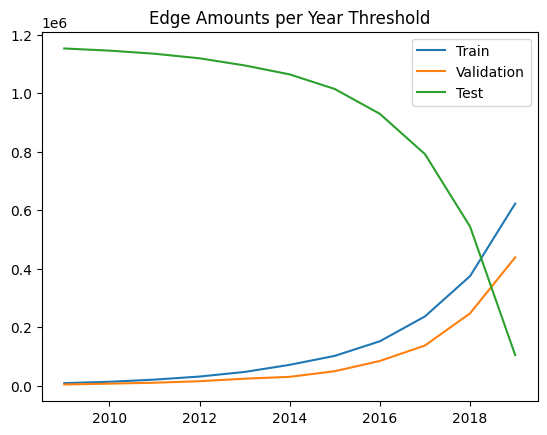

In [17]:
edge_amounts = pd.DataFrame(columns=['Train', 'Validation', 'Test'])
for year in range(2009, 2020):
    train_amount = (df['max_year'] < year).sum()
    validation_amount = (df['max_year'] == year).sum()
    test_amount = (df['max_year'] > year).sum()
    edge_amounts.loc[year] = [train_amount, validation_amount, test_amount]

edge_amounts.plot()
plt.title('Edge Amounts per Year Threshold')

In [18]:
def get_df(epoch):
    path = data_path_pat.format(epoch=epoch)
    df = pd.read_parquet(path)
    df = df.rename_axis(["i", "j"])
    df["year_i"] = df.index.get_level_values("i").map(year_map)
    df["year_j"] = df.index.get_level_values("j").map(year_map)
    df["max_year"] = df[["year_i", "year_j"]].max(axis=1)
    df["is_same_class"] = (
        (
            data.y.squeeze()[df.index.get_level_values("i").values]
            == data.y.squeeze()[df.index.get_level_values("j").values]
        )
        .cpu()
        .numpy()
    )
    return df

output_path = f"data/results/{dataset_name}/positional_graph_sage/{n_layers}layers_sensitivity_aucs.parquet"

if os.path.exists(output_path):
    model_auc_df = pd.read_parquet(output_path)
else:
    model_auc_df = pd.DataFrame(
        columns=["train_val_auc", "val_auc", "test_auc"],
        index=pd.MultiIndex.from_product(
            [range(1, 201), range(2009, 2020)], names=["epoch", "year"]
        ),
    )
    logging.info("Calculating AUCs for all epochs and threshold years.")
    for epoch in range(1, 201):
        logging.info(f"Epoch {epoch}")
        df = get_df(epoch)
        for year in range(2009, 2020):
            logging.info(f"Year {year}")
            train_mask = df["max_year"] < year
            validation_mask = df["max_year"] == year
            train_validation_mask = train_mask | validation_mask
            test_mask = df["max_year"] > year
            val_df = df[validation_mask]
            train_val_df = df[train_validation_mask]
            test_df = df[test_mask]
            auc_validation = roc_auc_score(val_df["is_same_class"], val_df["pred"])
            auc_train_validation = roc_auc_score(
                train_val_df["is_same_class"], train_val_df["pred"]
            )
            auc_test = roc_auc_score(test_df["is_same_class"], test_df["pred"])
            model_auc_df.loc[(epoch, year)] = [
                auc_train_validation,
                auc_validation,
                auc_test,
            ]
    model_auc_df.to_parquet(output_path)

model_auc_df

train_val_auc   val_auc  test_auc
epoch year                                  
1     2009      0.556878  0.544989  0.542157
      2010      0.564802  0.578818   0.54269
      2011      0.567295  0.578977  0.543009
      2012      0.570445  0.580087  0.543334
      2013      0.567192  0.561868  0.544527
...                  ...       ...       ...
200   2015      0.623055    0.6407  0.657126
      2016      0.633688   0.65049  0.657386
      2017      0.645487  0.662135  0.656404
      2018      0.652086  0.658117  0.655622
      2019      0.654578  0.656507  0.651902

[2200 rows x 3 columns]

In [20]:
output_path = f"data/results/{dataset_name}/positional_graph_sage/{n_layers}layers_sensitivity_aucs.parquet"
model_auc_df.to_parquet(output_path)

In [19]:
model_auc_df.sort_values('test_auc')

train_val_auc   val_auc  test_auc
epoch year                                  
1     2019       0.54093  0.551275  0.542077
      2009      0.556878  0.544989  0.542157
      2010      0.564802  0.578818   0.54269
      2011      0.567295  0.578977  0.543009
      2012      0.570445  0.580087  0.543334
...                  ...       ...       ...
52    2016      0.662458  0.683237  0.689554
50    2016      0.662647  0.683428  0.689677
47    2016      0.661809  0.682958  0.689801
49    2016      0.662572  0.683572  0.689942
48    2016       0.66226  0.683359  0.690002

[2200 rows x 3 columns]

## Model selection per year

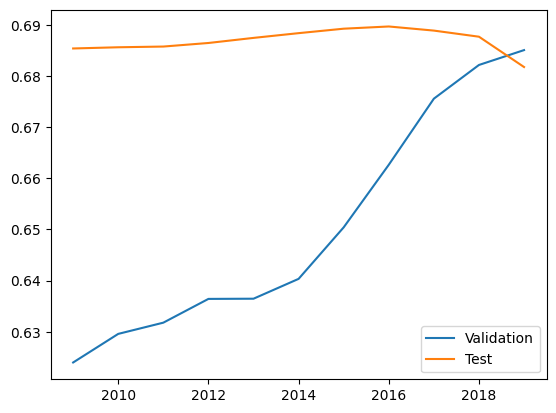

In [21]:
val_auc_dict = {}
test_auc_dict = {}
for year in range(2009, 2020):
    year_df = model_auc_df.query(f'year == {year}')
    max_val_row = year_df.sort_values('train_val_auc', ascending=False).iloc[0]
    train_val_auc, val_auc, test_auc = max_val_row.values
    val_auc_dict[year] = train_val_auc
    test_auc_dict[year] = test_auc

pd.Series(val_auc_dict).plot(label='Validation')
pd.Series(test_auc_dict).plot(label='Test')
plt.legend()

In [90]:
year_df['test_auc'].max()

0.6817513736739191

In [29]:
metrics = PositionalOmegaGraphSageCosSim.read_metrics(
    n_layers=n_layers,
    dataset='ogbn-arxiv'
)

### Data splits

In [15]:
year_series = pd.Series(data.node_year.cpu().numpy().squeeze())

<AxesSubplot: >

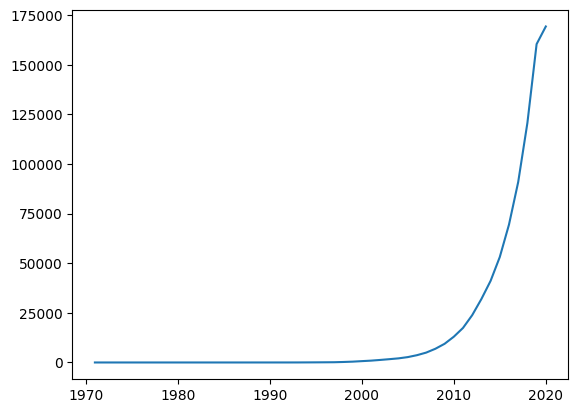

In [22]:
year_series.value_counts().sort_index().cumsum().plot()

Text(0.5, 1.0, 'Node Amounts per Year Threshold')

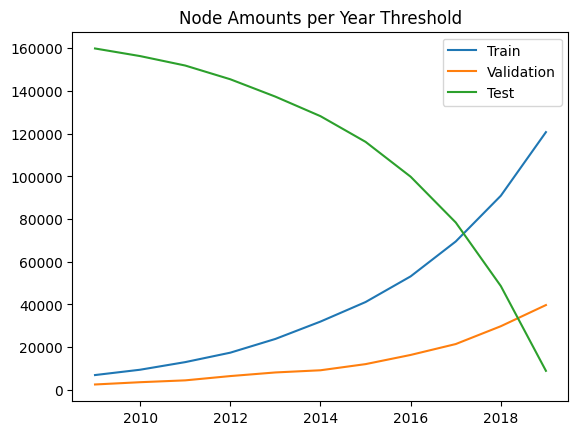

In [42]:
node_amounts = pd.DataFrame(columns=['Train', 'Validation', 'Test'])
for year in range(2009, 2020):
    train_amount = (year_series < year).sum()
    validation_amount = (year_series == year).sum()
    test_amount = (year_series > year).sum()
    node_amounts.loc[year] = [train_amount, validation_amount, test_amount]

node_amounts.plot()
plt.title('Node Amounts per Year Threshold')

In [39]:
node_years = data.node_year.cpu().numpy().squeeze()
edge_index

edge_amounts = pd.DataFrame(columns=['Train', 'Validation', 'Test'])
for year in range(2009, 2020):
    edges_train, edges_val, edges_test = get_train_val_test_edges_year(
        node_years, edge_index.cpu(), year)
    train_amount = edges_train.shape[1]
    val_amount = edges_val.shape[1]
    test_amount = edges_test.shape[1]
    edge_amounts.loc[year] = [train_amount, validation_amount, test_amount]


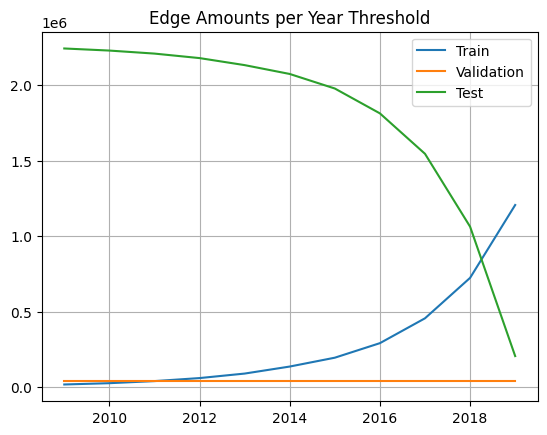

In [44]:
edge_amounts.plot()
plt.title('Edge Amounts per Year Threshold')
plt.grid()